# Salt Fluxes

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

In [3]:
# Set title size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16  # Titles larger

# Set axis label size
plt.rcParams['axes.labelsize'] = 14  # Labels slightly smaller

## Functions

In [4]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [5]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[['PRES_INTERPOLATED'], ['PRES_INTERPOLATED']],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    #ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    
    return ds_rho

In [6]:
def get_ds_binned(ds, lon_bins, lat_bins):
    
    ds_binned = xarray_reduce(
        ds,
        'LONGITUDE',
        'LATITUDE',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins)
        ),
        fill_value=np.nan,
        skipna=True)
    
    lon_l = np.arange(lon_bins[0],lon_bins[-1],3)
    lon_r = np.arange(lon_bins[1],lon_bins[-1]+1,3)
    lon_c = (lon_l + lon_r)/2

    lat_l = np.arange(lat_bins[0],lat_bins[-1],3)
    lat_r = np.arange(lat_bins[1],lat_bins[-1]+1,3)
    lat_c = (lat_l + lat_r)/2

    ds_binned = ds_binned.assign_coords({
        "lat_c": ("LATITUDE_bins", lat_c),
        "lat_l": ("LATITUDE_bins", lat_l),
        "lat_r": ("LATITUDE_bins", lat_r),
        "lon_c": ("LONGITUDE_bins", lon_c),
        "lon_l": ("LONGITUDE_bins", lon_l),
        "lon_r": ("LONGITUDE_bins", lon_r),
    })
    
    ds_binned = ds_binned.swap_dims({"LATITUDE_bins": "lat_c", "LONGITUDE_bins": "lon_c"})
    ds_binned = ds_binned.drop_vars(["LATITUDE_bins", "LONGITUDE_bins"])
    
    if isinstance(ds_binned, xr.Dataset):
        # For xarray.Dataset, use rename_dims and rename_vars
        ds_binned = ds_binned.rename_dims({"rho_grid": "density"}).rename_vars({"rho_grid": "density"})
    elif isinstance(ds_binned, xr.DataArray):
        # For xarray.DataArray, use rename to rename the dimension
        ds_binned = ds_binned.rename({"rho_grid": "density"})
    else:
        raise TypeError("Input must be an xarray.Dataset or xarray.DataArray")

    
    return ds_binned

## Term (1)

In [9]:
diff_rho = xr.open_dataset('/swot/SUM05/amf2288/diff_rho_3.nc')
K_rho = diff_rho.K_rho

In [10]:
K_rho = K_rho.rename({'rho_grid':'density'})

## Term (2)

In [11]:
lfilt = 100
rho_grid = np.arange(21,29,0.0025)
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-67.5,68,3)

In [12]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [20]:
sa_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_e_3.nc', chunks={'N_PROF':100000})

In [21]:
sa_e_z2 = sa_e.differentiate(coord='PRES_INTERPOLATED')**2

In [ ]:
%%time
sa_e_z2_filt = ff.da_filt_single(sa_e_z2, lfilt)

In [ ]:
sa_e_z2_filt.name = 'sa_e_z2_filt'
sa_e_z2_filt = sa_e_z2_filt.to_dataset()

In [ ]:
%%time
sa_e_z2_filt_rho = get_ds_rho(sa_e_z2_filt.chunk({'N_PROF':100000}), ds.SIG0, rho_grid, variables=['sa_e_z2_filt'])

In [ ]:
sa_e_z2_filt_rho

In [ ]:
%%time
term2 = get_ds_binned(sa_e_z2_filt_rho, lon_bins, lat_bins)

In [28]:
%%time
term2.to_netcdf('/swot/SUM05/amf2288/var-boxes/term2_sa.nc')

CPU times: user 53min 8s, sys: 36min 30s, total: 1h 29min 38s
Wall time: 40min 6s


## Term (3)

In [11]:
sa_m = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_m_3.nc', chunks={'N_PROF':100000})

In [12]:
sa_m.name = 'sa_m'
sa_m = sa_m.to_dataset()

In [13]:
%%time
sa_m_rho = get_ds_rho(sa_m, ds.SIG0, rho_grid, variables=['sa_m'])

Completed comp for sa_m
Completed sa_m
Completed merge
CPU times: user 20.1 s, sys: 10.9 s, total: 31 s
Wall time: 31.1 s


In [14]:
%%time
sa_m_rho_binned = get_ds_binned(sa_m_rho, lon_bins, lat_bins)

CPU times: user 25.6 ms, sys: 3.23 ms, total: 28.9 ms
Wall time: 25.2 ms


In [15]:
%%time
sa_m_rho_binned_dx = sa_m_rho_binned.differentiate('lon_c')
sa_m_rho_binned_dy = sa_m_rho_binned.differentiate('lat_c')

CPU times: user 7.72 ms, sys: 0 ns, total: 7.72 ms
Wall time: 7.7 ms


In [16]:
%%time
sa_m_rho_binned_dx.to_netcdf('/swot/SUM05/amf2288/var-boxes/sa_m_rho_binned_dx.nc')
sa_m_rho_binned_dy.to_netcdf('/swot/SUM05/amf2288/var-boxes/sa_m_rho_binned_dy.nc')

CPU times: user 1h 31min 27s, sys: 56min 52s, total: 2h 28min 19s
Wall time: 1h 10min 21s


In [17]:
term3 = np.sqrt(sa_m_rho_binned_dx**2 + sa_m_rho_binned_dy**2)

In [19]:
term3.to_netcdf('/swot/SUM05/amf2288/var-boxes/term3_sa.nc')

## Plots

In [26]:
ds_rho = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_rho_binned_high_res.nc')

In [41]:
sa_m_rho_binned_dx = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_m_rho_binned_dx.nc')
sa_m_rho_binned_dy = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_m_rho_binned_dy.nc')

In [7]:
%%time
term2_ds = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2_sa.nc').load()
term2 = term2_ds.sa_e_z2_filt.rename('term2')
term3 = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/term3_sa.nc').rename('term3').load()

CPU times: user 73.4 ms, sys: 358 ms, total: 432 ms
Wall time: 974 ms


In [13]:
%%time
salt_flux_dxdy = K_rho*(term2/term3)

CPU times: user 124 ms, sys: 276 ms, total: 400 ms
Wall time: 397 ms


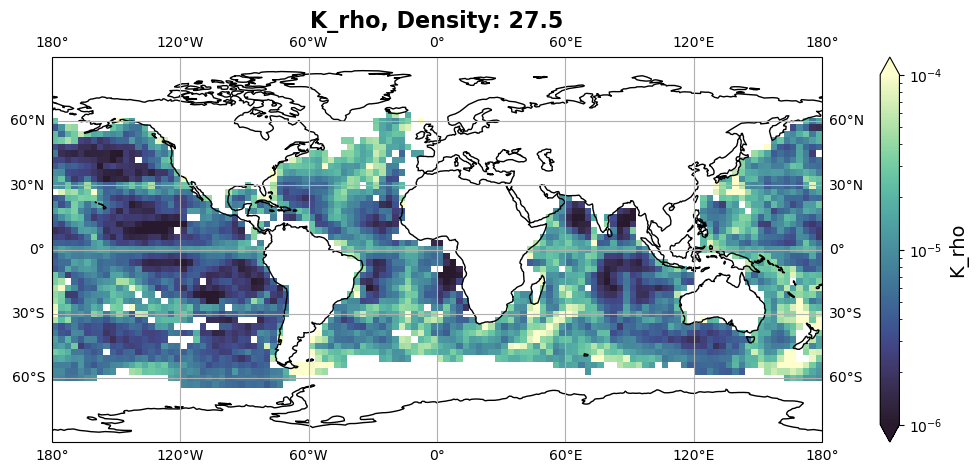

In [15]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
K_rho.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-4))
ax.set_title('K_rho, Density: {}'.format(np.round(term2.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/K_rho_275.png', bbox_inches='tight')

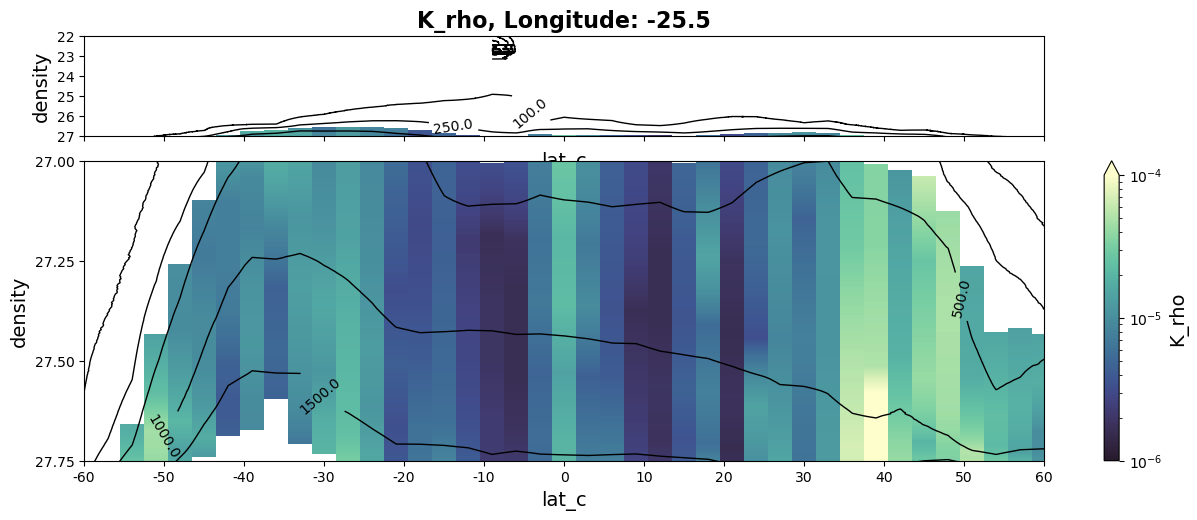

In [27]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

norm = colors.LogNorm(vmin=1e-6, vmax=1e-4)
levels = [100, 250, 500, 1000, 1500, 2000]

K_rho.sel(lon_c=lon, method='nearest').plot(ax=top_ax, x='lat_c', y='density', cmap=cmo.deep_r, norm=norm, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'K_rho, Longitude: {K_rho.sel(lon_c=lon, method="nearest").lon_c.values}')

K_rho.sel(lon_c=lon, method='nearest').plot(ax=bottom_ax, x='lat_c', y='density', cmap=cmo.deep_r, norm=norm)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/K_rho_275_sect.png', bbox_inches='tight')

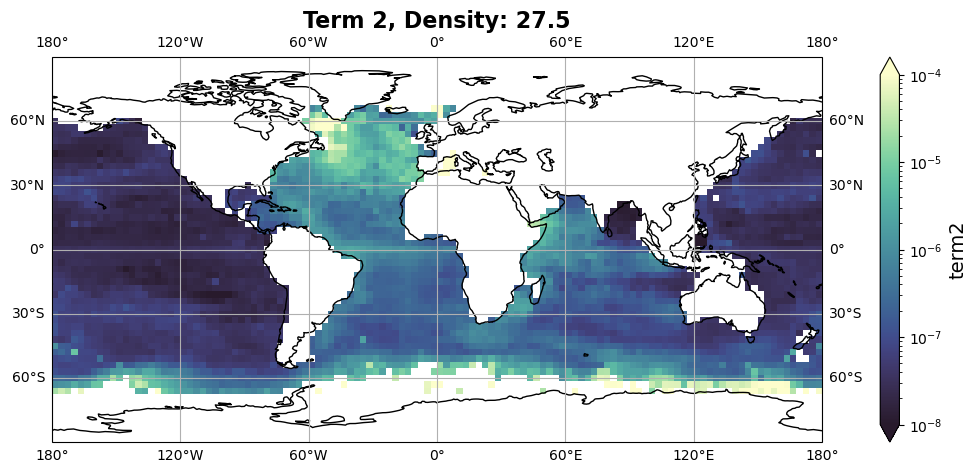

In [22]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
term2.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-8, vmax=1e-4))
ax.set_title('Term 2, Density: {}'.format(np.round(term2.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/term2_sa_275.png', bbox_inches='tight')

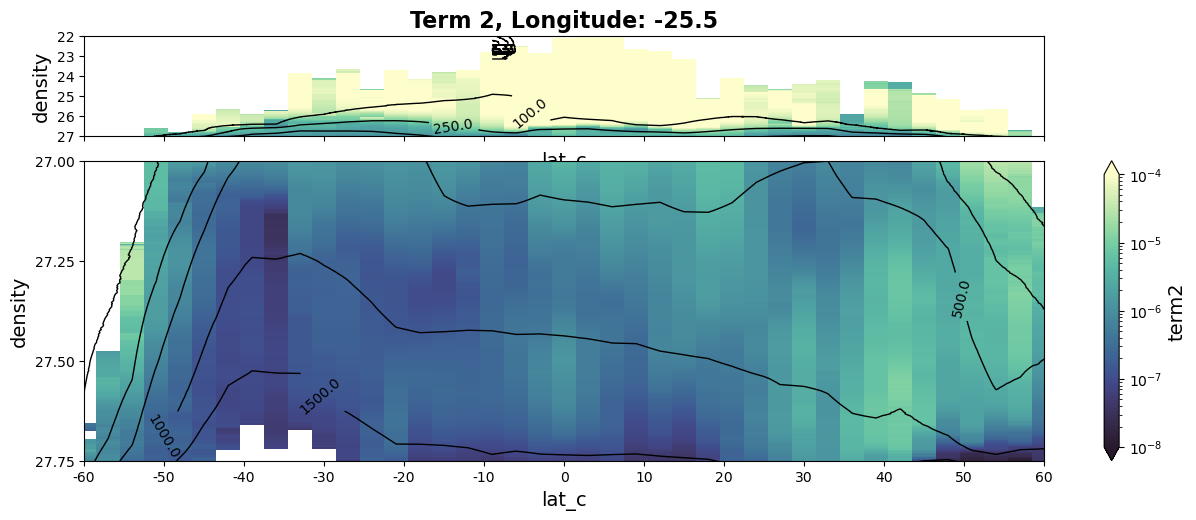

In [31]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

norm = colors.LogNorm(vmin=1e-8, vmax=1e-4)
levels = [100, 250, 500, 1000, 1500, 2000]

term2.sel(lon_c=lon, method='nearest').plot(ax=top_ax, x='lat_c', y='density', cmap=cmo.deep_r, norm=norm, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'Term 2, Longitude: {K_rho.sel(lon_c=lon, method="nearest").lon_c.values}')

term2.sel(lon_c=lon, method='nearest').plot(ax=bottom_ax, x='lat_c', y='density', cmap=cmo.deep_r, norm=norm)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/term2_sa_275_sect.png', bbox_inches='tight')

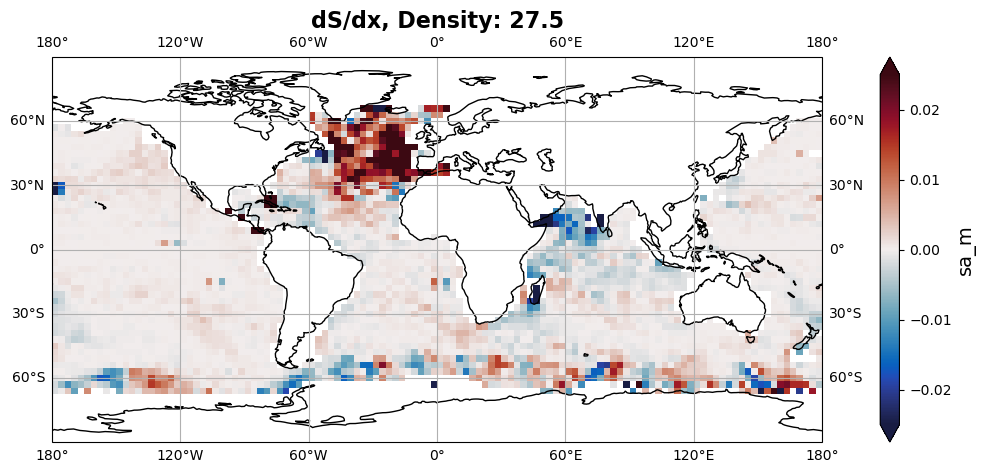

In [45]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
sa_m_rho_binned_dx.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.balance, vmin=-0.025, vmax=0.025)
ax.set_title('dS/dx, Density: {}'.format(np.round(term3.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/dSdx_275.png', bbox_inches='tight')

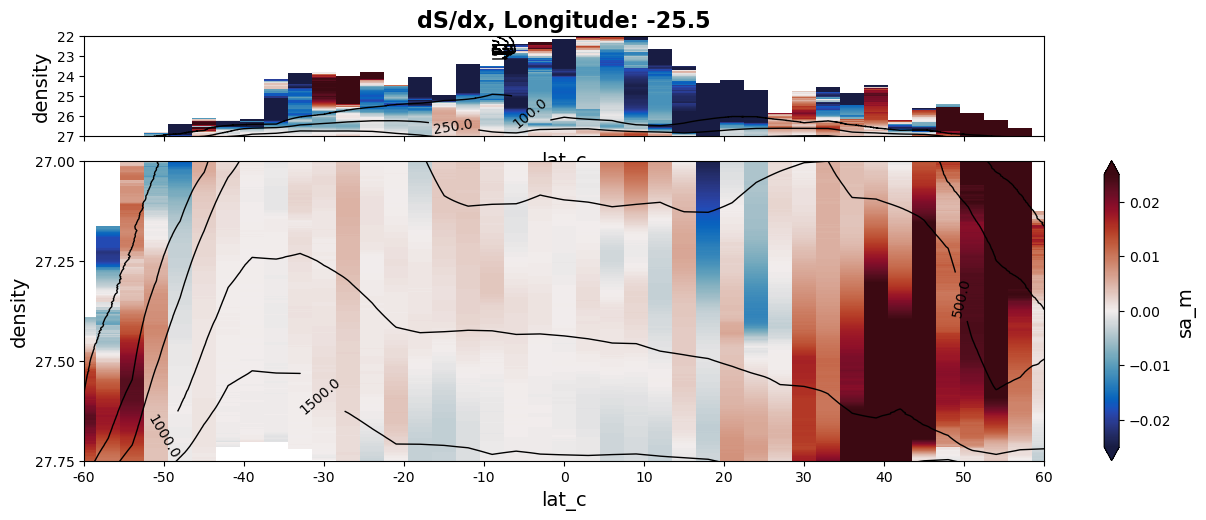

In [48]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

levels = [100, 250, 500, 1000, 1500, 2000]

sa_m_rho_binned_dx.sel(lon_c=lon, method='nearest').plot(ax=top_ax, x='lat_c', y='density', cmap=cmo.balance, vmin=-0.025, vmax=0.025, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'dS/dx, Longitude: {K_rho.sel(lon_c=lon, method="nearest").lon_c.values}')

sa_m_rho_binned_dx.sel(lon_c=lon, method='nearest').plot(ax=bottom_ax, x='lat_c', y='density', cmap=cmo.balance, vmin=-0.025, vmax=0.025)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/dSdx_275_sect.png', bbox_inches='tight')

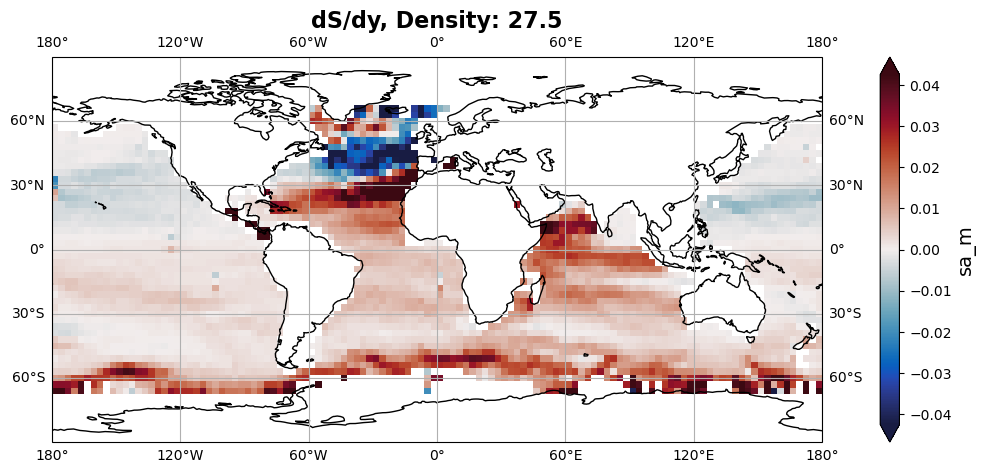

In [49]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
sa_m_rho_binned_dy.sa_m.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.balance, vmin=-0.045, vmax=0.045)
ax.set_title('dS/dy, Density: {}'.format(np.round(term3.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/dSdy_275.png', bbox_inches='tight')

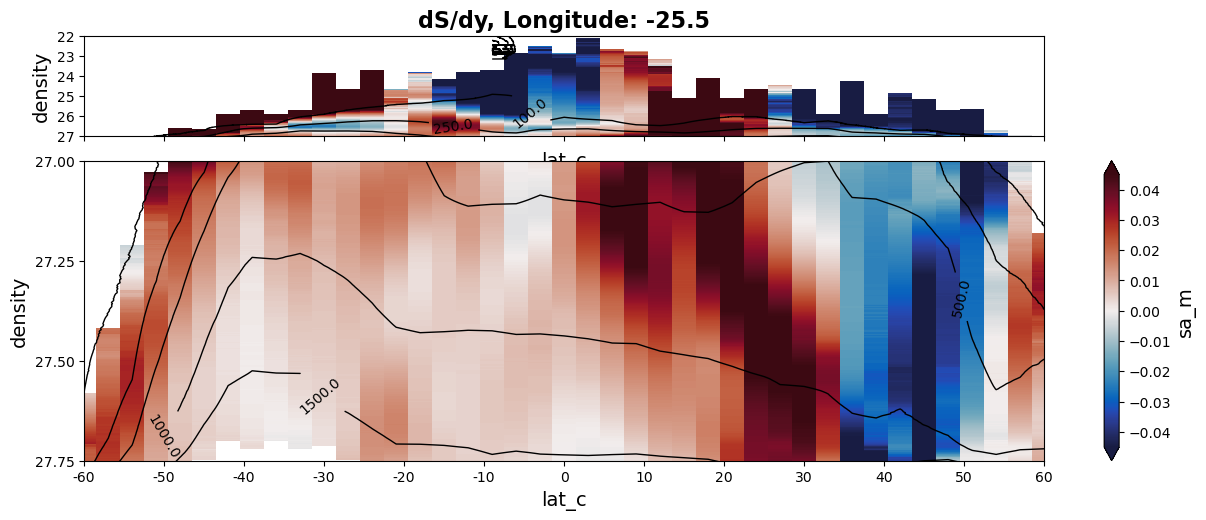

In [50]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

levels = [100, 250, 500, 1000, 1500, 2000]

sa_m_rho_binned_dy.sel(lon_c=lon, method='nearest').plot(ax=top_ax, x='lat_c', y='density', cmap=cmo.balance, vmin=-0.045, vmax=0.045, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'dS/dy, Longitude: {K_rho.sel(lon_c=lon, method="nearest").lon_c.values}')

sa_m_rho_binned_dy.sel(lon_c=lon, method='nearest').plot(ax=bottom_ax, x='lat_c', y='density', cmap=cmo.balance, vmin=-0.045, vmax=0.045)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/dSdy_275_sect.png', bbox_inches='tight')

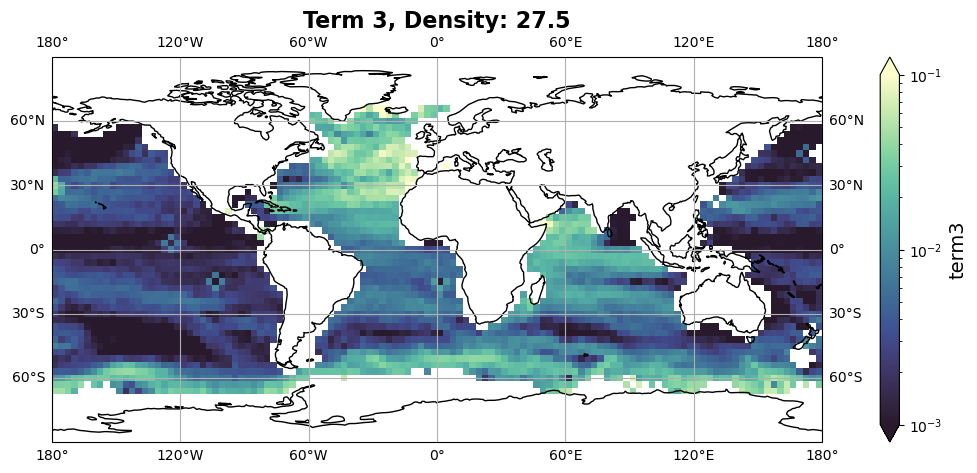

In [59]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
term3.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1))
ax.set_title('sqrt(dS/dx**2 + dS/dy**2), density: {}'.format(np.round(salt_flux_dxdy.sel(density=density, method='nearest').density.values, 1)))
ax.set_title('Term 3, Density: {}'.format(np.round(term3.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/term3_sa_275.png', bbox_inches='tight')

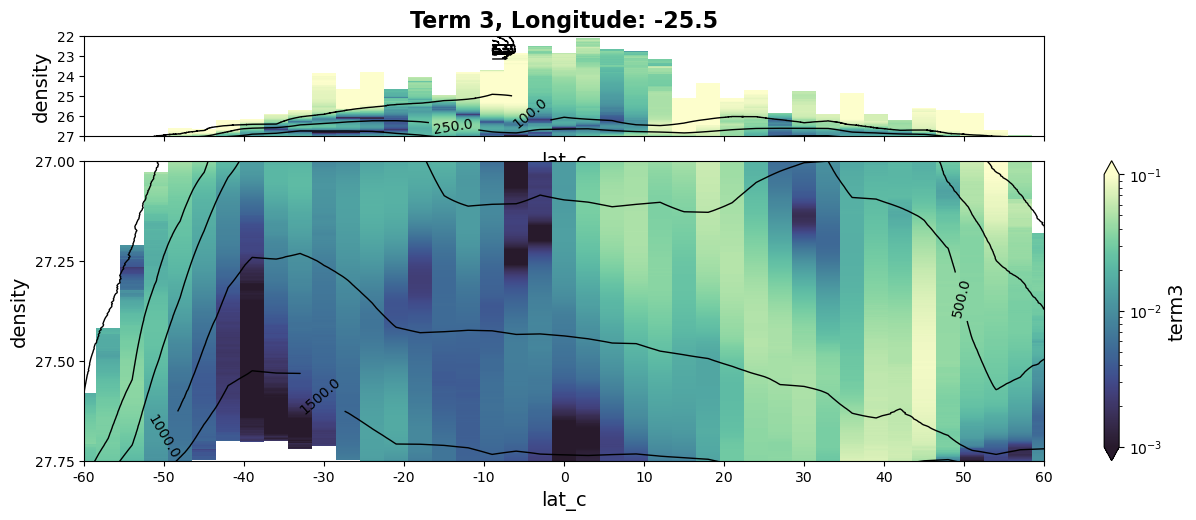

In [32]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

norm = colors.LogNorm(vmin=1e-3, vmax=1e-1)
levels = [100, 250, 500, 1000, 1500, 2000]

term3.sel(lon_c=lon, method='nearest').plot(ax=top_ax, x='lat_c', y='density', cmap=cmo.deep_r, norm=norm, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'Term 3, Longitude: {K_rho.sel(lon_c=lon, method="nearest").lon_c.values}')

term3.sel(lon_c=lon, method='nearest').plot(ax=bottom_ax, x='lat_c', y='density', cmap=cmo.deep_r, norm=norm)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/term3_sa_275_sect.png', bbox_inches='tight')

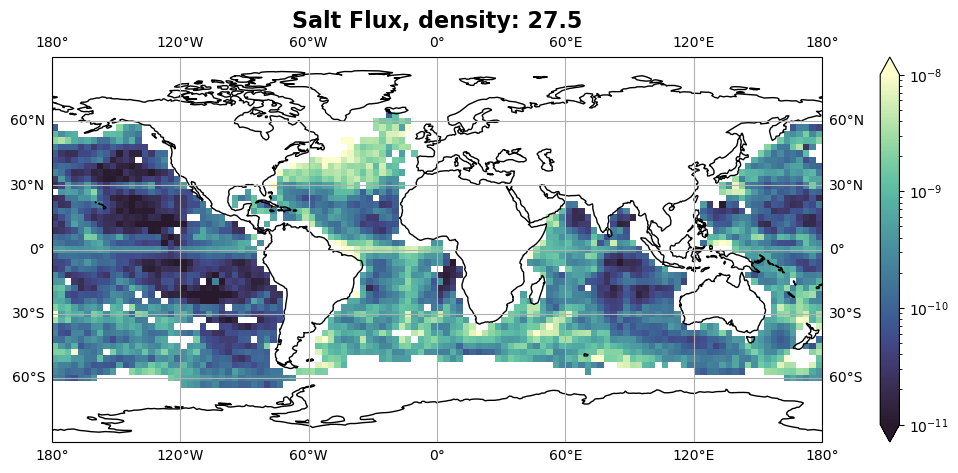

In [45]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
salt_flux_dxdy.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-11, vmax=1e-8))
plt.title('Salt Flux, density: {}'.format(np.round(salt_flux_dxdy.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/salt_flux_275.png', bbox_inches='tight')

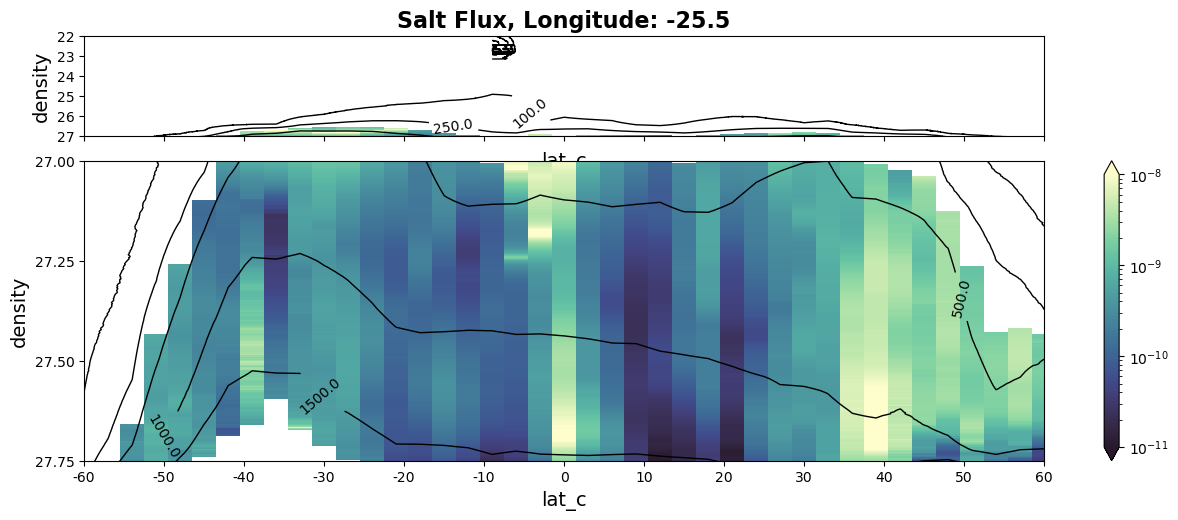

In [36]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

norm = colors.LogNorm(vmin=1e-11, vmax=1e-8)
levels = [100, 250, 500, 1000, 1500, 2000]

salt_flux_dxdy.sel(lon_c=lon, method='nearest').plot(ax=top_ax, x='lat_c', y='density', cmap=cmo.deep_r, norm=norm, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'Salt Flux, Longitude: {K_rho.sel(lon_c=lon, method="nearest").lon_c.values}')

salt_flux_dxdy.sel(lon_c=lon, method='nearest').plot(ax=bottom_ax, x='lat_c', y='density', cmap=cmo.deep_r, norm=norm)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/salt_flux_275_sect.png', bbox_inches='tight')